In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr 
import math
from pylab import *

#### Read in TSV Data.  Format Salary field properly.

In [2]:
df_total = pd.read_csv('test_player_dataframe_1.txt',sep='\t')

df_total.Salary = df_total['Salary'].str.replace('$','')
df_total.Salary = df_total['Salary'].str.replace(',','')
df_total.Salary = df_total['Salary'].astype(float)

### Create Weighted Average Dataframe 
Create a dataframe that represents the weighted averages of each player's seasons on their rookie contract.  This will give us a representation of their body of work up until the point of their new contract.  Store the player's new non-rookie contract in the same row so we can see the relationships between the weighted averages of statistics and their new contract.

In [3]:
players = df_total['Player'].unique()

list_of_rookie_contract_data = []
list_of_first_contract_data = []
list_of_columns_to_average = ['Age','G','GS','MP_x','FG','FGA',
 'FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB',
 'DRB','TRB','AST','STL','BLK','TOV','PF','PTS','MP_y','PER','TS%','3PAr',
 'FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS',
 'WS','WS/48','OBPM','DBPM','BPM','VORP']
list_of_averaged_rows = []

#For each player in original dataset, create a Rookie table of just his first 4 seasons
#Also create a Contract datatable of his first year with the new contract
for player in players:
    df_player = df_total[df_total['Player'] == player]
    df_player_rookie = df_player.iloc[0:3]
    df_player_contract = df_player.iloc[4:5]
#Append these individual dataframes to separate lists, they will later be concatendated into one larger dataframe    
    list_of_rookie_contract_data.append(df_player_rookie)
    list_of_first_contract_data.append(df_player_contract)

#############################################################################################
# Create a dataframe of the weight averages of numerical columns during players first 4 seasons
#############################################################################################    
    weight_array =[]
    total_minutes = 0
    for index, row in df_player_rookie.iterrows():
        #The weight used will be based off minutes played for each seasons
        weight = row.MP_x * row.G
        #Make an array of the weights for each season
        weight_array.append(weight)
        total_minutes = weight + total_minutes
    #If they didn't play in a given season, skip    
    if total_minutes == 0:
        continue
    #Normalize the weight array    
    weight_array[:] = [x / total_minutes for x in weight_array]

    ##Iterate through the new Rookie dataframe, apply weighted average for numerical columns
    ##If column is Salary, grab it from the Contract table
    ##If column is non-numeric, just add a placeholder value to the row
    new_row = []
    if len(df_player) <5:
        continue
    for column in df_player_rookie.columns:        
        if column in list_of_columns_to_average:
            new_row.append(np.dot(weight_array,df_player_rookie[column]))
        elif column == 'Salary':
            new_row.append(df_player.iloc[4:5]['Salary'].values[0])
        elif column == 'Salary%':
            new_row.append(df_player.iloc[4:5]['Salary%'].values[0])    
        else:
            var = df_player_rookie.iloc[:-2][column].values[0]
            new_row.append(var)
    list_of_averaged_rows.append(new_row)
list_of_averaged_rows = pd.Series(list_of_averaged_rows)

##Make the larger rookie and contract dataframes
df_rookie_total = pd.concat(list_of_rookie_contract_data)
df_contract_total = pd.concat(list_of_first_contract_data)
##Make the larger rookie_averages dataframe
df_rookie_averages = pd.DataFrame.from_items(zip(list_of_averaged_rows.index,list_of_averaged_rows.values)).T
df_rookie_averages.columns = list(df_total.columns.values)

In [68]:
from sklearn.linear_model import LinearRegression
independent_vars = df_rookie_averages.loc[:,['PTS','AST','TRB','BLK','TOV']]
print(len(df_rookie_averages['PTS']))
print(len(df_rookie_averages['Salary%']))
lm = LinearRegression()

#lm.fit(X=df_rookie_averages['PTS'].to_frame(),y=df_rookie_averages['Salary%'].to_frame())
lm.fit(X=independent_vars,y=df_rookie_averages['Salary%'].to_frame())

lm.get_params(deep=True)
#print(lm.score(X=df_rookie_averages['PTS'].to_frame(),y=df_rookie_averages['Salary%'].to_frame()))
print(lm.score(X=independent_vars,y=df_rookie_averages['Salary%'].to_frame()))
print(lm.coef_)
print(lm.intercept_)

766
766
0.620060476423
[[ 0.00843731  0.0093365   0.00738141  0.02882312 -0.01193533]]
[-0.02944301]


In [178]:
import statsmodels.api as sm

target = pd.DataFrame(df_rookie_averages['Salary%'])
independent_vars = df_rookie_averages.loc[:,['PTS','AST','TRB','BLK','DWS','Age']]
independent_vars.astype(float)
independent_vars.dropna(inplace=True)
independent_vars.describe()

independent_vars = sm.add_constant(independent_vars)
model = sm.OLS(list(target['Salary%'].astype(float)),independent_vars.astype(float)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     231.2
Date:                Sun, 03 Jun 2018   Prob (F-statistic):          1.50e-167
Time:                        16:00:11   Log-Likelihood:                 1287.0
No. Observations:                 766   AIC:                            -2560.
Df Residuals:                     759   BIC:                            -2527.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0778      0.025      3.075      0.002         0.028     0.127
PTS            0.0070      0.001     12.095      0.000         0.006     0.008
AST            0.0034      0.001      2.291      0.022         0.000     0.006
TRB            0.0033      0.001      2.294      0.022         0.000     0.006
BLK            0.0183      0.005      3.882      0.000         0.009     0.028
DWS            0.0182      0.003      6.777      0.000         0.013     0.024
Age           -0.0046      0.001     -4.284      0.000        -0.007    -0.002
==============================================================================
Omnibus:                       64.742   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.619
Skew:                           0.377   Prob(JB):                     1.00e-44
Kurtosis:                       5.404   Cond. No.                         388.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

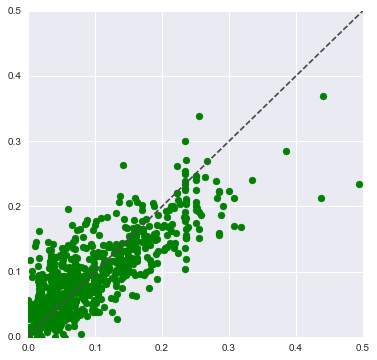

In [144]:
f, ax = plt.subplots(figsize=(6, 6))

plt.scatter(target, model.predict(), color="g", label="Linear")

ax.plot([0, 0.5], [0, 0.5], ls="--", c=".3")
ax.set(xlim=(0,0.5), ylim=(0,0.5))
plt.show()

## Ensemble Model Approach

In [132]:
df_big_men_averages = df_rookie_averages[(df_rookie_averages.Pos == 'PF')|(df_rookie_averages.Pos == 'C')]
df_wings_averages = df_rookie_averages[(df_rookie_averages.Pos == 'SF')|(df_rookie_averages.Pos == 'SG')]
df_pointguard_averages = df_rookie_averages[(df_rookie_averages.Pos == 'PG')]

### Point Guard Specific Sub-model

In [146]:
import statsmodels.api as sm

target = pd.DataFrame(df_pointguard_averages['Salary%'])
pg_independent_vars = df_pointguard_averages.loc[:,['3P','AST','ORB','BLK']]
pg_independent_vars.astype(float)
pg_independent_vars.dropna(inplace=True)
pg_independent_vars.describe()

pg_independent_vars = sm.add_constant(pg_independent_vars)
pg_model = sm.OLS(list(target['Salary%'].astype(float)),pg_independent_vars.astype(float)).fit()

pg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     56.48
Date:                Sun, 03 Jun 2018   Prob (F-statistic):           1.21e-28
Time:                        15:25:10   Log-Likelihood:                 254.13
No. Observations:                 150   AIC:                            -498.3
Df Residuals:                     145   BIC:                            -483.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0257      0.009     -2.906      0.004        -0.043    -0.008
3P             0.0196      0.008      2.594      0.010         0.005     0.034
AST            0.0154      0.002      6.907      0.000         0.011     0.020
ORB            0.0358      0.014      2.575      0.011         0.008     0.063
BLK            0.1266      0.033      3.830      0.000         0.061     0.192
==============================================================================
Omnibus:                        2.905   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                3.059
Skew:                           0.015   Prob(JB):                        0.217
Kurtosis:                       3.699   Cond. No.                         41.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

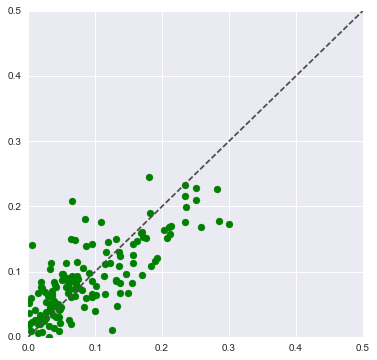

In [136]:
f, ax = plt.subplots(figsize=(6, 6))

plt.scatter(target, pg_model.predict(), color="g", label="Linear")

ax.plot([0, 0.5], [0, 0.5], ls="--", c=".3")
ax.set(xlim=(0,0.5), ylim=(0,0.5))
plt.show()

### Big Man Specific Sub-model

In [173]:
import statsmodels.api as sm

target = pd.DataFrame(df_big_men_averages['Salary%'])
bm_independent_vars = df_big_men_averages.loc[:,['3P','AST','ORB','BLK','TOV']]
bm_independent_vars.astype(float)
bm_independent_vars.dropna(inplace=True)
bm_independent_vars.describe()

bm_independent_vars = sm.add_constant(bm_independent_vars)
big_man_model = sm.OLS(list(target['Salary%'].astype(float)),bm_independent_vars.astype(float)).fit()

big_man_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     98.91
Date:                Sun, 03 Jun 2018   Prob (F-statistic):           6.35e-63
Time:                        15:56:25   Log-Likelihood:                 519.88
No. Observations:                 328   AIC:                            -1028.
Df Residuals:                     322   BIC:                            -1005.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0374      0.007     -5.268      0.000        -0.051    -0.023
3P             0.0191      0.011      1.680      0.094        -0.003     0.042
AST            0.0113      0.007      1.599      0.111        -0.003     0.025
ORB            0.0228      0.005      4.287      0.000         0.012     0.033
BLK            0.0279      0.006      4.904      0.000         0.017     0.039
TOV            0.0460      0.009      5.054      0.000         0.028     0.064
==============================================================================
Omnibus:                       19.392   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.590
Skew:                           0.218   Prob(JB):                     4.63e-11
Kurtosis:                       4.814   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

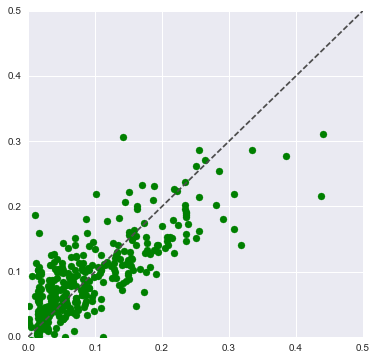

In [142]:
f, ax = plt.subplots(figsize=(6, 6))

plt.scatter(target, big_man_model.predict(), color="g", label="Linear")

ax.plot([0, 0.5], [0, 0.5], ls="--", c=".3")
ax.set(xlim=(0,0.5), ylim=(0,0.5))
plt.show()

### Wing Specific Sub-model

In [171]:
import statsmodels.api as sm

target = pd.DataFrame(df_wings_averages['Salary%'])
wing_independent_vars = df_wings_averages.loc[:,['3P','AST','ORB','BLK']]
wing_independent_vars.astype(float)
wing_independent_vars.dropna(inplace=True)
wing_independent_vars.describe()

wing_wing_independent_vars = sm.add_constant(wing_independent_vars)
wing_model = sm.OLS(list(target['Salary%'].astype(float)),wing_independent_vars.astype(float)).fit()

wing_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     265.0
Date:                Sun, 03 Jun 2018   Prob (F-statistic):           3.29e-94
Time:                        15:56:01   Log-Likelihood:                 433.27
No. Observations:                 286   AIC:                            -858.5
Df Residuals:                     282   BIC:                            -843.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
3P             0.0272      0.006      4.747      0.000         0.016     0.038
AST            0.0178      0.003      6.075      0.000         0.012     0.024
ORB            0.0300      0.006      4.759      0.000         0.018     0.042
BLK            0.0419      0.012      3.477      0.001         0.018     0.066
==============================================================================
Omnibus:                       65.009   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.467
Skew:                           1.087   Prob(JB):                     7.80e-34
Kurtosis:                       5.841   Cond. No.                         9.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

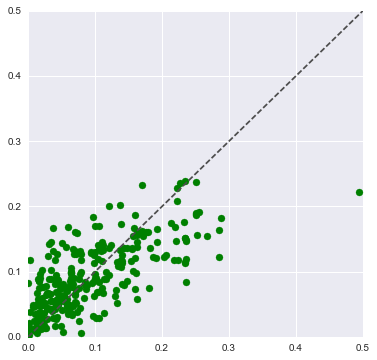

In [140]:
f, ax = plt.subplots(figsize=(6, 6))

plt.scatter(target, wing_model.predict(), color="g", label="Linear")

ax.plot([0, 0.5], [0, 0.5], ls="--", c=".3")
ax.set(xlim=(0,0.5), ylim=(0,0.5))
plt.show()

### General Sub Model
This is the part of the ensemble model that is not position specific.  It does not use variables used by the position specific sub models.

In [180]:
import statsmodels.api as sm

target = pd.DataFrame(df_rookie_averages['Salary%'])
independent_vars = df_rookie_averages.loc[:,['PTS','DWS','Age']]
independent_vars.astype(float)
independent_vars.dropna(inplace=True)
independent_vars.describe()

independent_vars = sm.add_constant(independent_vars)
gen_model = sm.OLS(list(target['Salary%'].astype(float)),independent_vars.astype(float)).fit()

gen_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     430.3
Date:                Sun, 03 Jun 2018   Prob (F-statistic):          1.78e-163
Time:                        16:02:15   Log-Likelihood:                 1268.5
No. Observations:                 766   AIC:                            -2529.
Df Residuals:                     762   BIC:                            -2510.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0988      0.026      3.852      0.000         0.048     0.149
PTS            0.0078      0.000     17.785      0.000         0.007     0.009
DWS            0.0281      0.002     13.199      0.000         0.024     0.032
Age           -0.0052      0.001     -4.768      0.000        -0.007    -0.003
==============================================================================
Omnibus:                       71.541   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.567
Skew:                           0.483   Prob(JB):                     4.16e-42
Kurtosis:                       5.244   Cond. No.                         378.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Create the General components of all the position specific sub-models.

In [199]:
gen_model_pg_independent_vars = independent_vars = df_pointguard_averages.loc[:,['PTS','DWS','Age']]
gen_model_pg_independent_vars.astype(float)
gen_model_pg_independent_vars.dropna(inplace=True)
gen_model_pg_independent_vars = sm.add_constant(gen_model_pg_independent_vars)

gen_model_bm_independent_vars = independent_vars = df_big_men_averages.loc[:,['PTS','DWS','Age']]
gen_model_bm_independent_vars.astype(float)
gen_model_bm_independent_vars.dropna(inplace=True)
gen_model_bm_independent_vars = sm.add_constant(gen_model_bm_independent_vars)

gen_model_wing_independent_vars = independent_vars = df_wings_averages.loc[:,['PTS','DWS','Age']]
gen_model_wing_independent_vars.astype(float)
gen_model_wing_independent_vars.dropna(inplace=True)
gen_model_wing_independent_vars = sm.add_constant(gen_model_wing_independent_vars)

#### Find weights for the general vs. position specific sub-models.
For each value of p, weight the general model and the position specific sub-models
From this weighted value, compute the root mean squared error against the actual data points
Calculate the average root mean squared error from all 3 position specific models.

In [209]:
for i in range (1,10):
    p=i/10
    pg_model_avg = p * pg_model.predict(pg_independent_vars) + (1-p) * gen_model.predict(gen_model_pg_independent_vars)
    weight_pg_rmse = np.mean(((pg_model_avg - df_pointguard_averages['Salary%'])**2))**0.5
    #print(weight_pg_rmse)
    
    bm_model_avg = p * big_man_model.predict(bm_independent_vars) + (1-p) * gen_model.predict(gen_model_bm_independent_vars)
    weight_bm_rmse = np.mean(((bm_model_avg - df_big_men_averages['Salary%'])**2))**0.5
    #print(weight_bm_rmse)
    
    wing_model_avg = p * wing_model.predict(wing_independent_vars) + (1-p) * gen_model.predict(gen_model_wing_independent_vars)
    weight_wing_rmse = np.mean(((wing_model_avg - df_wings_averages['Salary%'])**2))**0.5
    #print(weight_wing_rmse)
    
    overall_rmse = (weight_pg_rmse + weight_bm_rmse + weight_wing_rmse) / 3
    
    print('Pos specific weight', p , overall_rmse)

Pos specific weight 0.1 0.0448295731835
Pos specific weight 0.2 0.0446004486902
Pos specific weight 0.3 0.0445527249397
Pos specific weight 0.4 0.0446869653001
Pos specific weight 0.5 0.0450014519538
Pos specific weight 0.6 0.04549229404
Pos specific weight 0.7 0.0461536647384
Pos specific weight 0.8 0.0469781343676
Pos specific weight 0.9 0.0479570571575


In [201]:
pg_ssr = sum(((pg_model.predict(pg_independent_vars) - df_pointguard_averages['Salary%'])**2))
print(pg_ssr)

gen_pg_ssr = sum(((gen_model.predict(gen_model_pg_independent_vars) - df_pointguard_averages['Salary%'])**2))
print(gen_pg_ssr)

weight_pg_ssr = sum(((model_avg - df_pointguard_averages['Salary%'])**2))
print(weight_pg_ssr)

0.296515359263
0.250898011106
0.280937283497


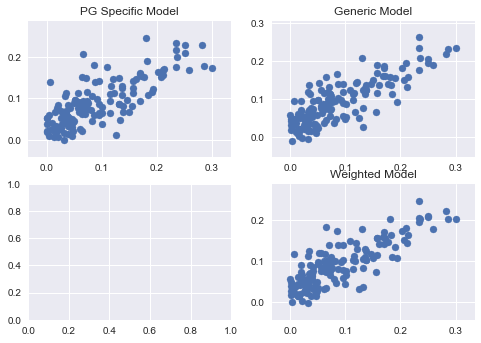

In [185]:
f, axarr = plt.subplots(2, 2)

axarr[0,0].scatter(df_pointguard_averages['Salary%'],pg_model.predict(pg_independent_vars),label='linear')
axarr[0,0].set_title('PG Specific Model')
axarr[0,1].scatter(df_pointguard_averages['Salary%'],gen_model.predict(gen_model_pg_independent_vars),label='linear')
axarr[0,1].set_title('Generic Model')
axarr[1,1].scatter(df_pointguard_averages['Salary%'],model_avg,label='linear')
axarr[1,1].set_title('Weighted Model')
plt.show()